In [1]:
%run ../../common/import_all.py

import cv2
import os

from common.setup_notebook import set_css_style, setup_matplotlib, config_ipython
config_ipython()
setup_matplotlib()
set_css_style()

# Object Detection

Object detection is the set of methodologies aimed at instructing a machine to understand if there is something in the image and where it is. These days Deep Learning approaches are the state-of-the-art silver bullets for these types of tasks, however the approaches described here are nevertheless brilliant and still useful in many cases.

## Haar cascades

Haar cascades, whose original paper by Viola and Jones [[1]](#haar), dates back from 2001 and it's a brilliant piece of work. It works by training a **cascade classifier** on positive (contain object) and negative (do not contain object) images. The word *Haar* (a name, originally) for this algorithm comes from the fact that the features it is trained on are called *Haar features* and this is due to the fact that they mirror the Haar wavelets, a family of step (mathematical) functions conceived by A Haar back at the start of the twentieth century [[2]](#wavelets). 

The idea of the Haar features has been formalised in the aforementioned paper, which has actually been inspired by a slightly older paper (1998) by Papageorgiou et al [[3]](#papa). 

### Haar features

<img src="../../imgs/haar.jpg" width="500"/>

The figure above illustrates the Haar features, which are of three types: 

* (A): *edge* features;
* (B): *line* features;
* (C): *four-rectangle* features

The Haar classifier is trained by moving these rectangles over each training image and computing the sum of of pixels' intensities under the dark and the light areas; afterwards, the differences of these is computed and compared to a threshold, which is meant to separate object from no-object in the training images. For example, to detect eyes, because the pixels in the eyes regions are darker than those in the cheeks, a line feature with the dark part above would be a good feature.

### Implementation of the training process

<img src="../../imgs/integral-image.jpg" align="left" width="300" style="margin:20px 50px"/>

Because the Haar features procedure would have to be run on each subsection of the image, the training process would be unfeasible with many images. What actually happens is that the algorithm uses *integral images*: 2-dimensional lookup tables containing the sum of pixels in the top-left part of the original image. The Figure on the left illustrates the concept, which can be formulated as 

$$
I(x, y) = \sum_{x' \leq x, y' \leq y} i(x', y') \ ,
$$

meaning that the value at point $(x, y)$ in table is the sum of all pixels above and to the left of it. From the image, the sum would be $D-B-C+A$, where the letters indicate the respective areas top-left of points: only four lookups are then needed,  and here is why this makes everything much faster.

### The classifier and the cascades

This way, a weak classifier for each feature is built. A strong classifier, an **AdaBoost**, weights all these weak classifiers and is capable of selecting the most relevant features as well. These strong classifiers are then organised into a **cascade**, whereby there is one at each stage.

Authors of the paper proved a very high accuracy with 600 features and a $95\%$ accuracy with 200 features in the case of face detection.

## Detecting a human/face with OpenCV and Haar cascades

OpenCV comes with some [already trained](https://github.com/opencv/opencv/tree/master/data/haarcascades) Haar cascade classifiers for human detection, but also for the detection of cats and car plates (quite handy!). The ones about humans have been trained for the detection of

* frontal face
* profile face
* eye
* eye behind glasses
* full body
* lower body
* upper body
* smiles

We will use the frontal face model to demonstrate the detection of a face in an image and the eye model to detect eyes as well. This follows this OpenCV [tutorial](http://docs.opencv.org/3.1.0/d7/d8b/tutorial_py_face_detection.html).

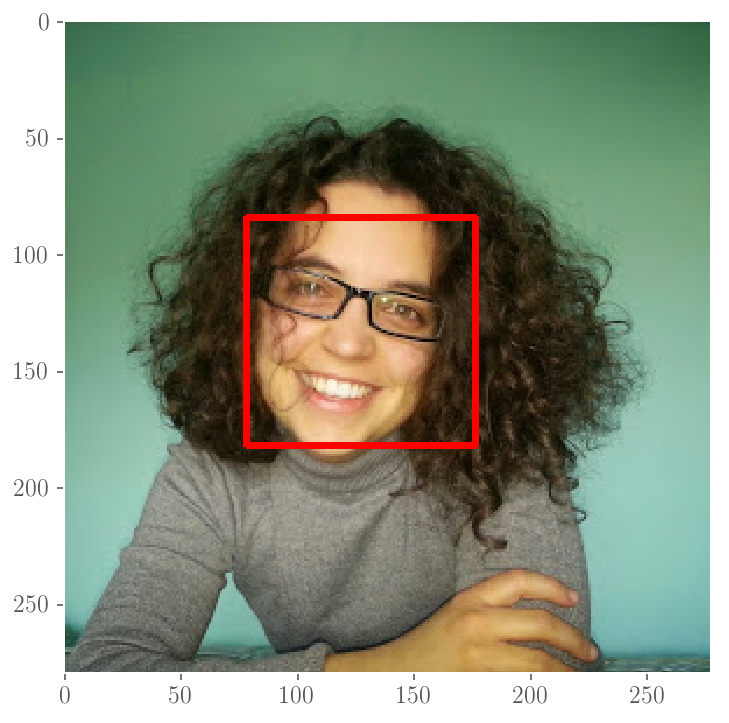

In [28]:
# Read image: we'll use my beautiful face ... (transform into RGB as OpenCV reads in BGR)
image = cv2.imread('../../imgs/foto_martina.jpg')
RGB_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Transform image in grayscale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# use the trained model for frontal face
# have to pass path to where model is stored
face_cascade = cv2.CascadeClassifier(os.getenv('HOME') + 
                                     '/Desktop/packages/opencv-3.2.0/data/haarcascades/' + 
                                     'haarcascade_frontalface_default.xml')

# detect my face and where it is (draw ROI around it), detection is on the grayscale one
objects = face_cascade.detectMultiScale(image_gray, scaleFactor=1.3, minNeighbors=5)
for (x,y,w,h) in objects:
    cv2.rectangle(RGB_image, (x,y), (x+w,y+h), (255, 0, 0), 2)
        
plt.imshow(RGB_image)
plt.grid()
plt.show();

## Histogram of Oriented Gradients (HOG)

The Histogram of Oriented Gradients (*HOG*) is a methodology used for object detection. [[6]](#hog) count the occurrences of gradient orientation in localised portions of the image. A local object can be described by a distribution of intensity gradients. The image gets divided into cells and for each cell a histogram of the gradient directions is computed. 

The descriptor is a concatenation of these histograms. For accuracy reasons, the local histograms are normalised with a measure of intensity across a larger region of the image (block) which guarantees better invariance to changes in illumination and shadowing.

Advantages: a local cell is invariant to geometrical and photometric transformations except for the object orientation. This makes the method particularly suited for the recognition of humans (pedestrians) in the image as sampling permits individual body movements to be ignored so long as the upright position is mantained.

After extracting the features with a HOG descriptor, a SVM classifier is applied.

## References

1. <a name="haar"></a> P Viola, M Jones, [**Rapid object detection using a boosted cascade of simple features**](http://www.merl.com/publications/docs/TR2004-043.pdf), *Proceedings of the 2001 IEEE Computer Society Conference on Computer Vision and Pattern Recognition*, 1, 2001
2. <a name="wavelets"></a> [Wikipedia](https://en.wikipedia.org/wiki/Haar_wavelet) on Haar wavelets
3. <a name="papa"></a> C P Papageorgiou, M Oren, T Poggio, **A general framework for object detection**, *IEEE sixth international conference on Computer vision*, 1998
4. <a name="blog"></a> A nice [blog](https://singhgaganpreet.wordpress.com/2012/10/14/training-haar-cascade/) on the training of Haar cascades
5. <a name="hc-wiki"></a> [Wikipedia](https://en.wikipedia.org/wiki/Viola–Jones_object_detection_framework#Cascade_architecture) on the Viola-Jones work
6. <a name="hog"></a> N Dalal, B Triggs, [Histograms of oriented gradients for human detection](https://hal.inria.fr/file/index/docid/548512/filename/hog_cvpr2005.pdf), *2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition*, 1 IEEE, 2005